# Signal to Noise Test

### Motivation

In this notebook we will look at how the Zernike polynomial estimation performance from the Wavefront Estimation Calculation changes as a function of the magnitude of the test star with the background noise level held constant. 

### Performance Metric
Our performance metric in this first version will be the RMS value between OPD results and the Zernike polynomials given by `ts_wep` output.

### Test Data
The test data was created on the UW *epyc* machine using `runSnrAnalysis.py` in the `ts_phosim/notebooks/analysis_scripts` directory.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('../analysis_tools/')
from calcMetrics import calcMetrics

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data_dir = '/astro/store/epyc/projects/lsst_comm/ts_phosim/notebooks/analysis_data/signal_to_noise_test/150x150yOffset/'

In [5]:
calcMagMetrics = calcMetrics()

## Magnitude Test

In [8]:
mag_array = np.arange(10., 16.1, 0.5)
ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []
for mag in mag_array:
    opdZkFilePath = os.path.join(data_dir, 'opd.zer.mag.%.1f' % (mag))
    wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.mag.%.1f' % (mag))
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)
zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))

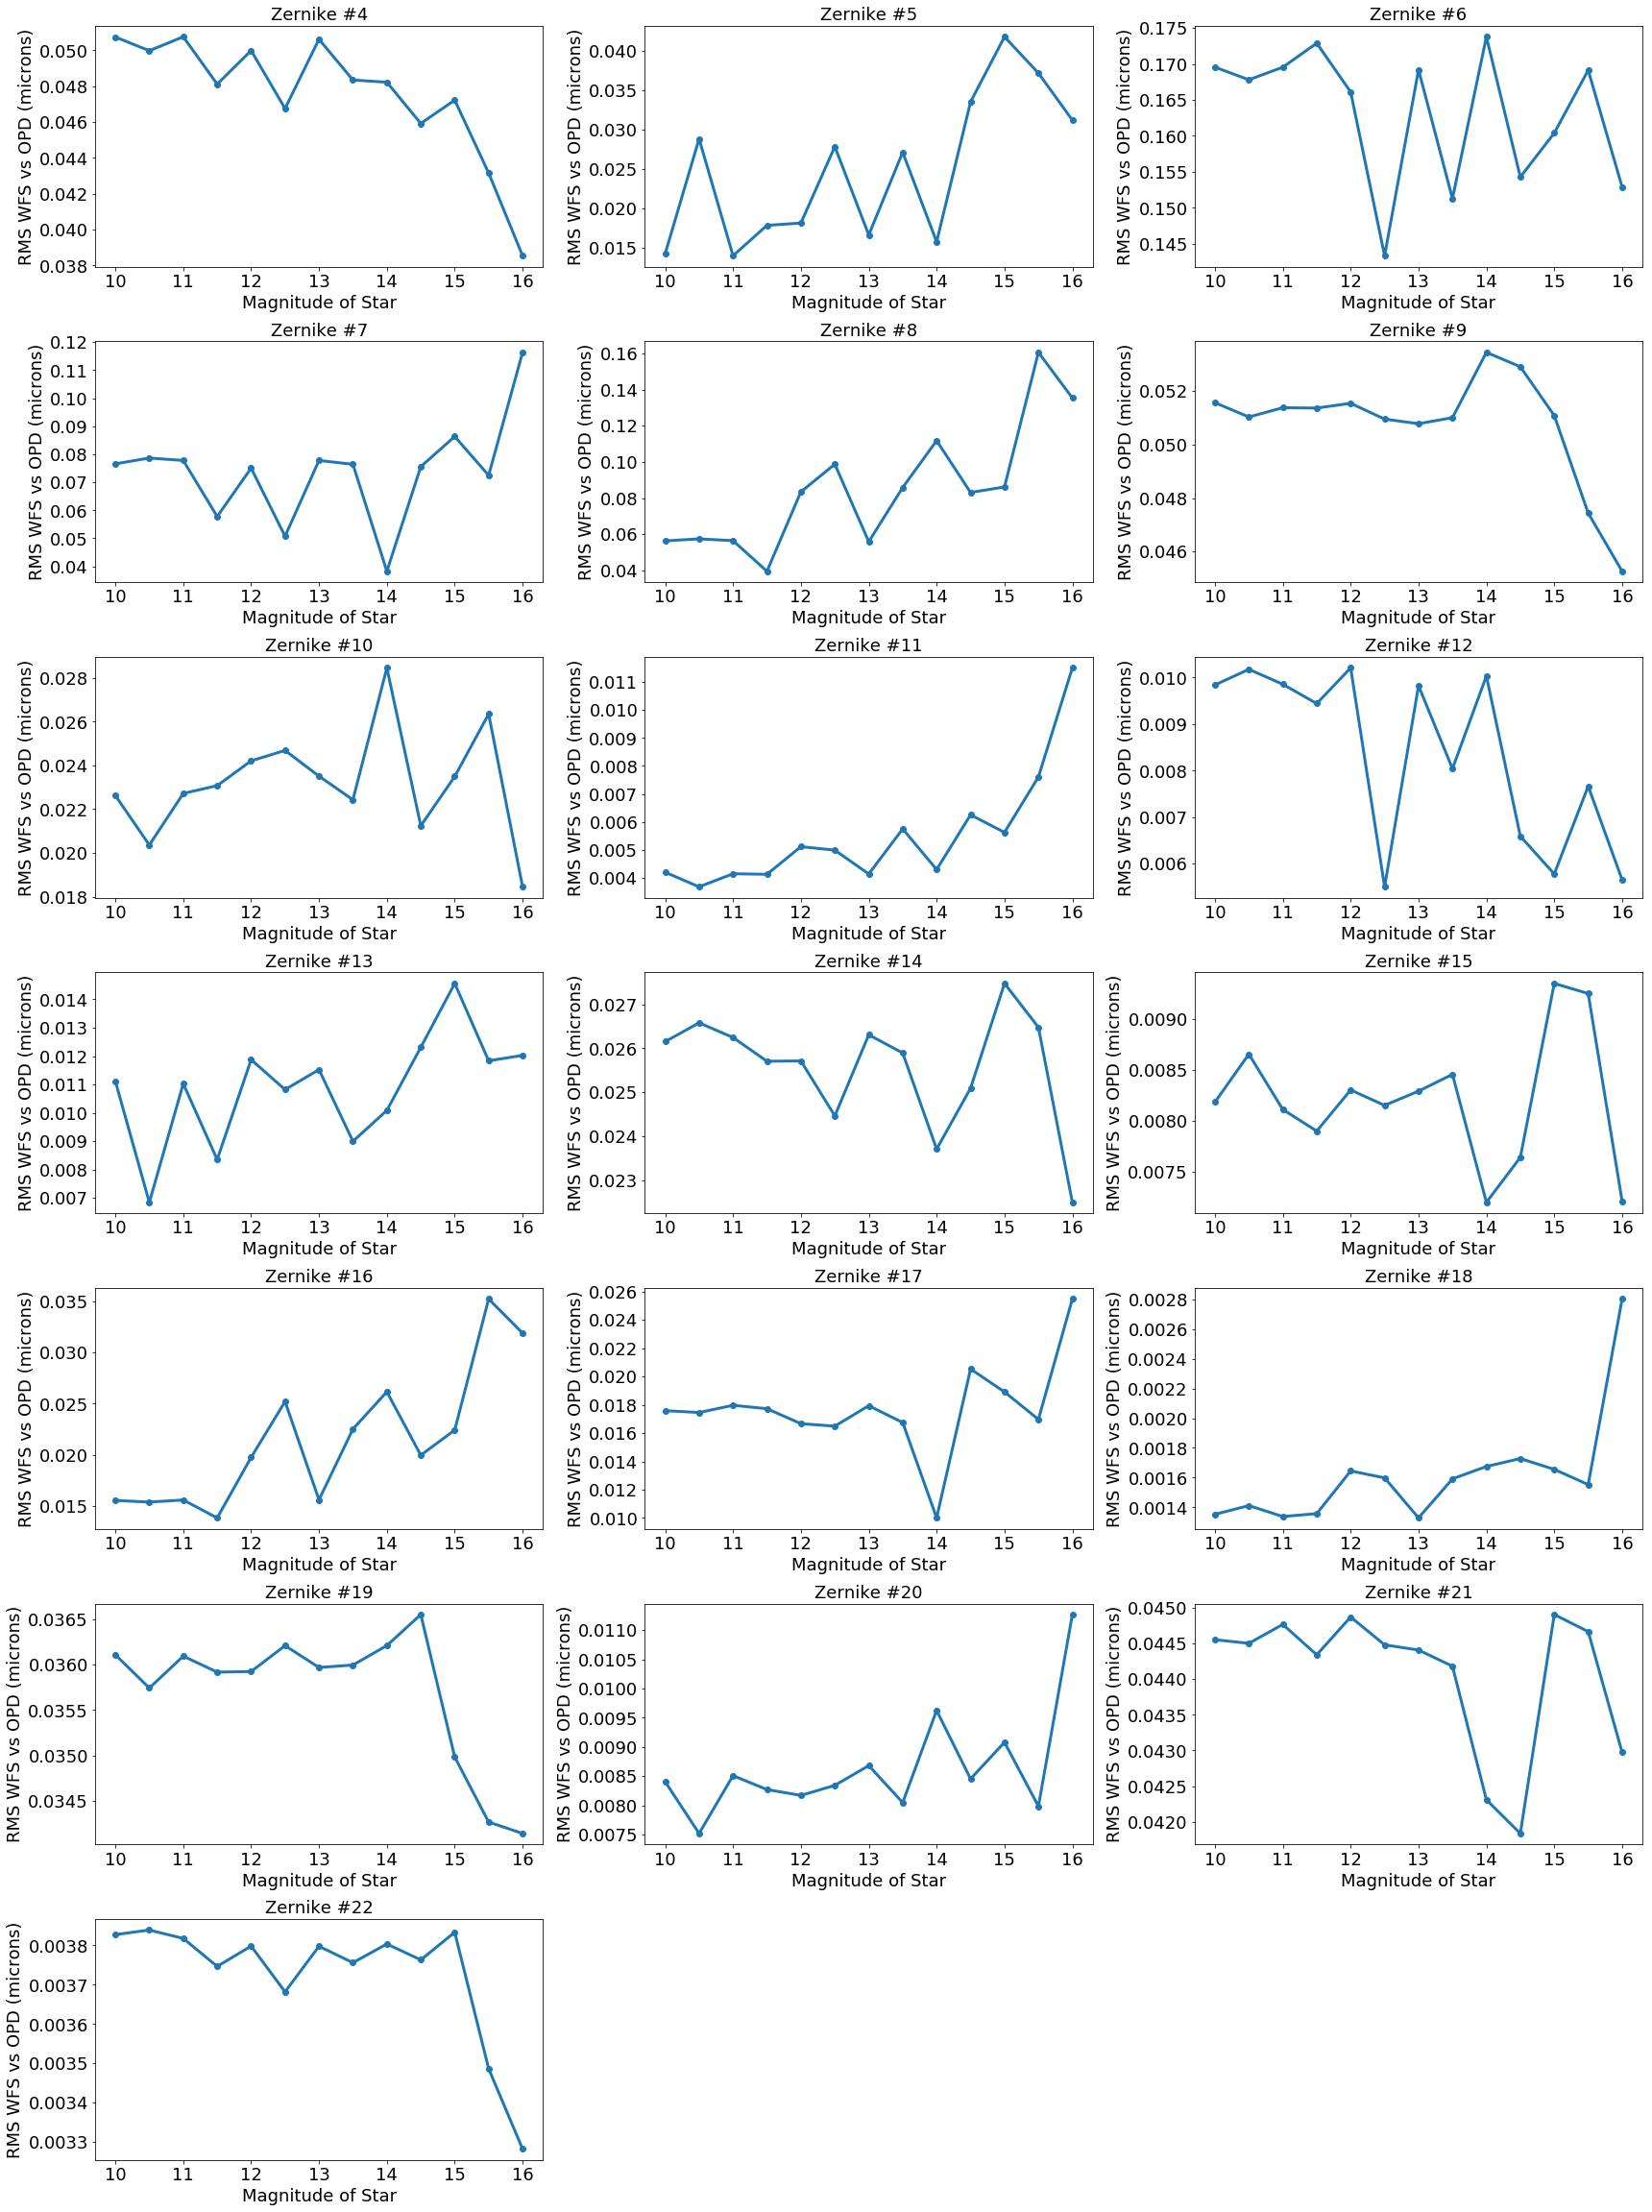

In [9]:
fig = plt.figure(figsize=(24,36))

for zernike in range(19):
    fig.add_subplot(8, 3, zernike+1)
    plt.plot(mag_array, np.sqrt(np.mean(np.square(zernikeErrors[zernike]), axis=0)), '-o', lw=3)
    plt.xlabel('Magnitude of Star', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
    #plt.legend(fontsize=16)
    plt.title('Zernike #%i' % (zernike+4), size=18)
    
plt.tight_layout()

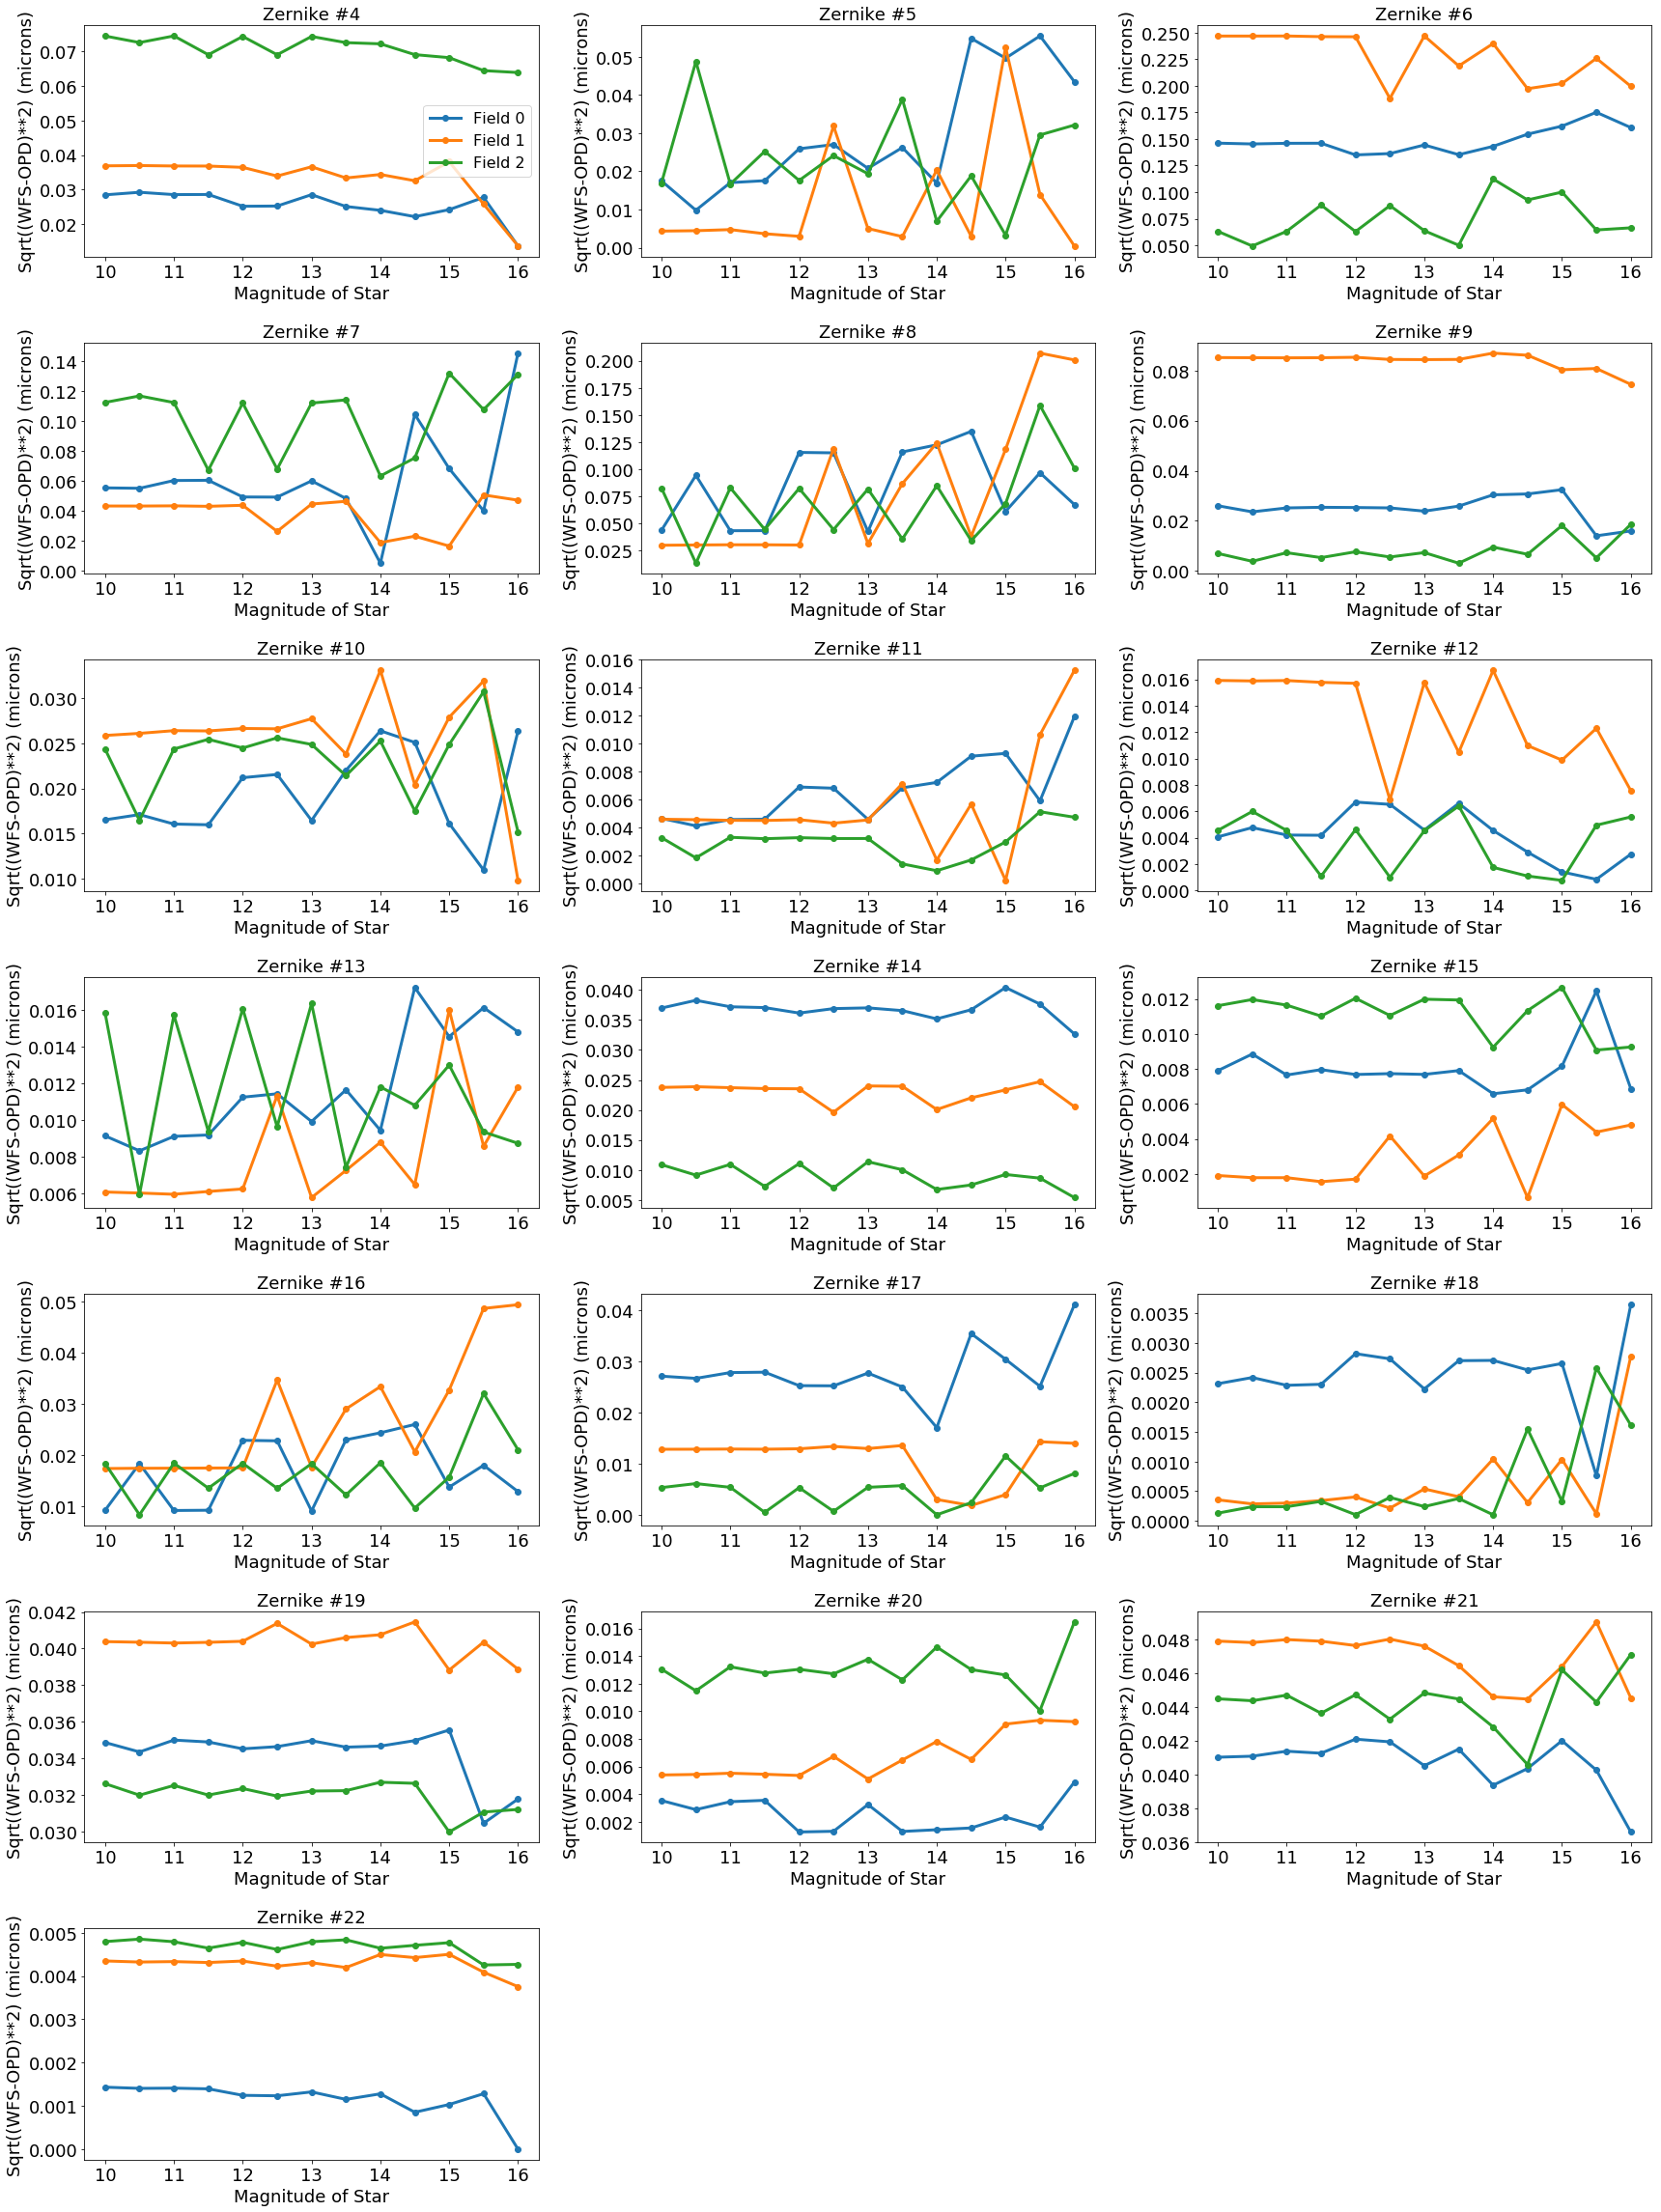

In [11]:
fig = plt.figure(figsize=(24,36))

for zernike in range(19):
    fig.add_subplot(8, 3, zernike+1)
    for ccd in range(3):
        plt.plot(mag_array, zernikeErrors[zernike, ccd], '-o', lw=3, label='Field %i' % ccd)
    plt.xlabel('Magnitude of Star', size=18)
    plt.ylabel('Sqrt((WFS-OPD)**2) (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
    if zernike == 0:
        plt.legend(fontsize=16)
    plt.title('Zernike #%i' % (zernike+4), size=18)
    
plt.tight_layout()

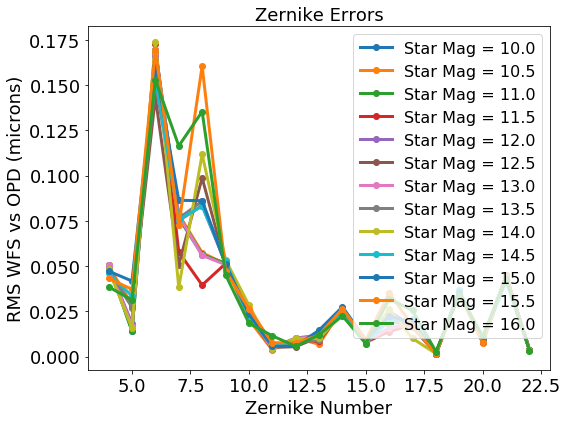

In [12]:
fig = plt.figure(figsize=(8,6))

for i in range(len(mag_array)):
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), '-o', lw=3, label='Star Mag = %.1f' % mag_array[i])
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors', size=18)
    
plt.tight_layout()

#### Generate CCD map of error values

In [14]:
starCat = np.genfromtxt(os.path.join(data_dir, 'starCat.txt'), names=['field', 'ra', 'dec', 'mag'])

In [15]:
starCat['ra'][:3] = starCat['ra'][:3] - 360.

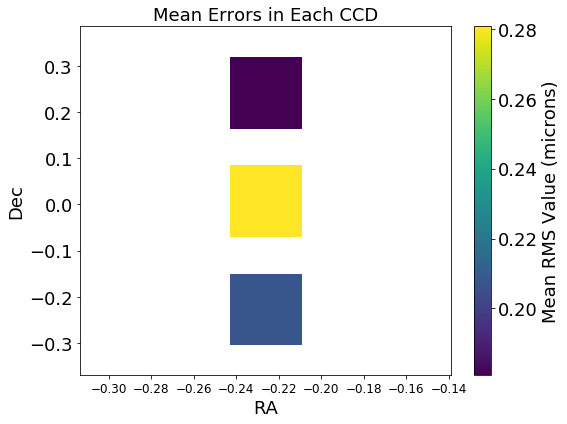

In [18]:
fig = plt.figure(figsize=(8,6))
plt.scatter(starCat['ra'], starCat['dec'], c=np.mean(np.sqrt(np.array(ssrFieldVals)), axis=0), s=5000, marker='s')
plt.xlabel('RA', size=18)
plt.ylabel('Dec', size=18)
plt.xticks(size=12)
plt.yticks(size=18)
cbar = plt.colorbar()
cbar.set_label('Mean RMS Value (microns)', size=18)
cbar.ax.tick_params(labelsize=18)
plt.title('Mean Errors in Each CCD', size=18)
plt.tight_layout()